In [1]:
import numpy as np
import pandas as pd
import xgboost
import matplotlib.pyplot as plt

from sklearn import tree, ensemble, model_selection
from sklearn.datasets import load_diabetes, load_wine

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score


classification_data_info = load_wine()
classification_feature_names = classification_data_info.feature_names

regression_data_info = load_diabetes()
regression_feature_names = regression_data_info.feature_names


test_data_ratio = 0.3

random_state = 0

n_estimators = 100
learning_rate =1e-1
max_depth = 3

In [2]:
class RegressionDataLoader:
  def __init__(self, data_info, feature_names, test_data_ratio, random_state):
    self.data_info = data_info
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.random_state = random_state

    self.data_infos = self.get_data_infos()
    self.data, self.label = self.get_dataset()

    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()
    self.min_max_normalize_data()

  def __call__(self, flag):
    if flag == 'train':
        return self.train_data, self.train_label
    else:
        return self.test_data, self.test_label

  def get_data_infos(self):
    df = pd.DataFrame(self.data_info.data, columns=self.feature_names)
    df['label'] = self.data_info.target

    return df

  def get_dataset(self):
    data, label = self.data_infos.drop(columns=['label']), self.data_infos['label']

    return data, label

  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.data, self.label, test_size=self.test_data_ratio, random_state = self.random_state
    )
    return train_data, train_label, test_data, test_label

  def min_max_normalize_data(self):
    min_values = np.min(self.train_data, axis=0)
    max_values = np.max(self.train_data, axis=0)

    self.train_data = (self.train_data - min_values) / (max_values - min_values)
    self.test_data = (self.test_data - min_values) / (max_values - min_values)


regression_dataloader = RegressionDataLoader(regression_data_info, regression_feature_names, test_data_ratio, random_state)
regression_train_data, regression_train_label = regression_dataloader('train')
regression_test_data, regression_test_label = regression_dataloader('test')

print(f'regression train data: {regression_train_data.shape}/regression train label: {regression_train_label.shape}')
print(f'regression test data: {regression_test_data.shape}/regressiontest label: {regression_test_label.shape}')

regression train data: (309, 10)/regression train label: (309,)
regression test data: (133, 10)/regressiontest label: (133,)


In [3]:
class SklearnGradientBoostingRegressor:
  def __init__(self, feature_names, n_estimators, learning_rate, max_depth, random_state):
    self.feature_names = feature_names
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate
    self.max_depth = max_depth
    self.random_state = random_state

    self.regressor = ensemble.GradientBoostingRegressor(
        n_estimators=self.n_estimators,
        learning_rate = self.learning_rate,
        max_depth=self.max_depth,
        random_state=self.random_state
    )

  def __call__(self, data):
    return self.regressor.predict(data)

  def train_model(self, train_data, train_label):
      self.regressor.fit(train_data, train_label)

  def test_model(self, test_data, test_label):
    pred = self.regressor.predict(test_data)
    mse = mean_squared_error(test_label, pred)
    mae = mean_absolute_error(test_label, pred)

    print('mse: {}/mae: {}'.format(mse, mae))

  def plot_feature_importance(self):
    importances = self.regressor.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), np.array(self.feature_names)[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()


class XGBoostRegressor:
  def __init__(self, feature_names, n_estimators, learning_rate, max_depth, random_state):
    self.feature_names = feature_names
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate
    self.max_depth = max_depth
    self.random_state = random_state

    self.regressor = xgboost.XGBRegressor(
        n_estimators=self.n_estimators,
        learning_rate = self.learning_rate,
        max_depth=self.max_depth,
        random_state=self.random_state
    )

  def __call__(self, data):
    return self.regressor.predict(data)

  def train_model(self, train_data, train_label):
      self.regressor.fit(train_data, train_label)

  def test_model(self, test_data, test_label):
    pred = self.regressor.predict(test_data)
    mse = mean_squared_error(test_label, pred)
    mae = mean_absolute_error(test_label, pred)

    print(f'mse: {mse}/mae: {mae}')

  def plot_feature_importance(self):
    xgboost.plot_importance(self.regressor, importance_type='weight')
    plt.show()

print('Gradient Boosted Trees for Regression')
sklearn_gbdt_regressor= SklearnGradientBoostingRegressor(regression_feature_names, n_estimators, learning_rate, max_depth, random_state)
sklearn_gbdt_regressor.train_model(regression_train_data, regression_train_label)
sklearn_gbdt_regressor.test_model(regression_test_data, regression_test_label)

print('XGBoost for Regression')
xgboost_regressor= XGBoostRegressor(regression_feature_names, n_estimators, learning_rate, max_depth, random_state)
xgboost_regressor.train_model(regression_train_data, regression_train_label)
xgboost_regressor.test_model(regression_test_data, regression_test_label)

Gradient Boosted Trees for Regression
mse: 3661.0295154460323/mae: 48.154551278222335
XGBoost for Regression
mse: 3589.695815421562/mae: 47.22885582142307


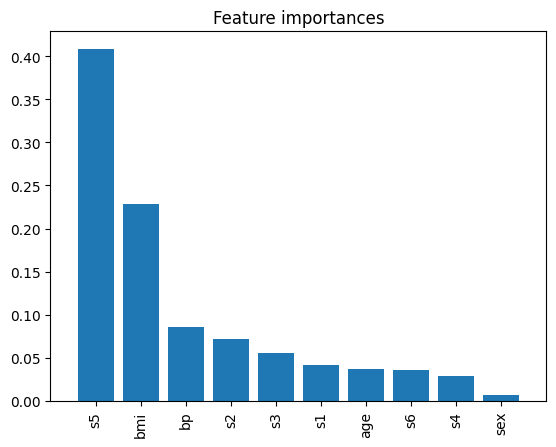

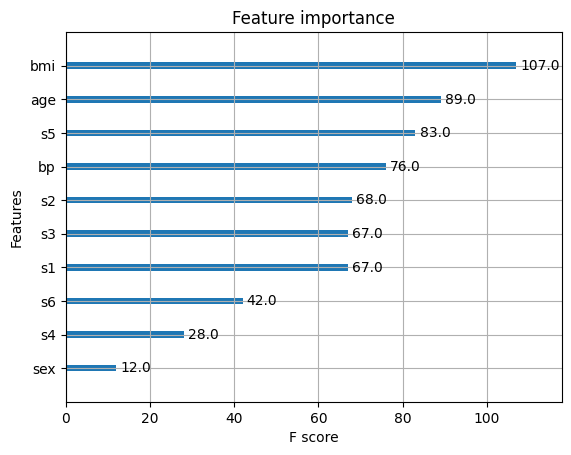

In [4]:
sklearn_gbdt_regressor.plot_feature_importance()
xgboost_regressor.plot_feature_importance()

In [5]:
class ClassificationDataLoader:
  def __init__(self, data_info, feature_names, test_data_ratio, random_state):
    self.data_info = data_info
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.random_state = random_state

    self.data_infos = self.get_data_infos()
    self.data, self.label = self.get_dataset()

    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()
    self.min_max_normalize_data()

  def __call__(self, flag):
    if flag == 'train':
      return self.train_data, self.train_label
    elif flag == 'test':
      return self.test_data, self.test_label

  def get_data_infos(self):
    df = pd.DataFrame(self.data_info.data, columns=self.feature_names)
    df['label'] = self.data_info.target

    return df

  def get_dataset(self):
    data, label = self.data_infos.drop(columns=['label']), self.data_infos['label']

    return data.to_numpy().astype(np.float32), label.to_numpy().astype(np.float32)

  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.data, self.label, test_size=self.test_data_ratio, random_state = self.random_state
    )
    return train_data.astype(np.float32), train_label.astype(np.float32), test_data.astype(np.float32), test_label.astype(np.float32)

  def min_max_normalize_data(self):
    min_values = np.min(self.train_data, axis=0)
    max_values = np.max(self.train_data, axis=0)

    self.train_data = (self.train_data - min_values) / (max_values - min_values)
    self.test_data = (self.test_data - min_values) / (max_values - min_values)

classifcation_dataloader = ClassificationDataLoader(classification_data_info, classification_feature_names, test_data_ratio, random_state)
classifcation_train_data, classifcation_train_label = classifcation_dataloader('train')
classifcation_test_data, classifcation_test_label = classifcation_dataloader('test')

print(f'classification train data: {classifcation_train_data.shape}/classification train label: {classifcation_train_label.shape}')
print(f'classification test data: {classifcation_test_data.shape}/classification test label: {classifcation_test_label.shape}')

classification train data: (124, 13)/classification train label: (124,)
classification test data: (54, 13)/classification test label: (54,)
